# Оптимизация потребления электроэнергии при обработке стали

## Описание проекта

В целях оптимизации производственных расходов металлургический комбинат решил уменьшить потребление электроэнергии при обработке стали. Обработка стали проводится итеративно. В конце каждой итерации измеряется температура стали и производится её химический анализ. В случае достижения целевого химического состава и оптимальной температуры плавки обработка стали останавливается. В рамках проекта необходимо построить модель, которая предскажет температуру стали на финальной итерации обработки.

## План выполнения проекта:
1. Обзор и предобработка данных:
  * обработка дубликатов, аномалий, выбросов, пропусков
  * приведение типов данных
  * проведение необходимых расчётов с целью добавления новых признаков
  * группировка и агрегация данных
2. Подготовка признаков:
  *  Формирование итогового датафрейма с признаками для обучения модели
  *  Удаление сильно коррелирующих признаков
  *  Деление на тестовую и обучающую выборку, выделение целевого признака
  *  Масштабирование признаков
3. Подбор параметров моделей:
  *  Линейная регрессия
  *  Дерево решений
  *  Случайный лес
  *  Модель градиентного бустинга
4. Обучение модели, показавшей наилучшую метрику на этапе подбора параметров, и расчёт метрики качества на тестовой выборке

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error


pd.options.display.float_format = '{: .2f}'.format
pd.options.mode.chained_assignment = None

## Обзор данных

In [2]:
def df_common_info(df):
    """
    Выводит общую информацию по датафрейму
    """
    print('Размер:')
    display(df.shape)
    display(df.head())
    print('\nМетрики:')
    display(df.describe())

    print('\nОбщая информация:')
    display(df.info())

    print('\nНазвания столбцов:')
    display(df.columns)

    if df.duplicated().sum() > 0:
      print('\nКоличество полных дубликатов:', df.duplicated().sum())
      display(df[df.duplicated()])
    else:
      print("Дубликатов нет")
    return

### Данные об электродах

In [3]:
data_arc= pd.read_csv("../datasets/final_steel/data_arc.csv")
df_common_info(data_arc)

Размер:


(14876, 5)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.98,0.69
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.81,0.52
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.74,0.50
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.66,1.06
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.69,0.41



Метрики:


,key,Активная мощность,Реактивная мощность
count,14876.00,14876.00,14876.00
mean,1615.22,0.67,0.45
std,934.57,0.41,5.88
min,1.00,0.03,-715.50
25%,806.00,0.40,0.29
50%,1617.00,0.56,0.42
75%,2429.00,0.86,0.64
max,3241.00,3.73,2.68



Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None


Названия столбцов:


Index(['key', 'Начало нагрева дугой', 'Конец нагрева дугой',
       'Активная мощность', 'Реактивная мощность'],
      dtype='object')

Дубликатов нет


In [4]:
data_arc['key'].nunique()

3214

**Вывод:** 

* Пропусков нет, дубликатов нет. 
* Столбцы "Начало нагрева дугой" и "Конец нагрева дугой" необходимо привести к типу datetime
* Встречаются названия столбцов на кириллице
* В столбце "reactive_energy" встречаются аномалии (min = -715)
* Одному ключу соответствует несколько записей.
* Всего 3214 уникальных ключей

Таким образом необходимо переименовать столбцы (привести к snake_case) и обработать аномальные значения.

### Данные о сыпучих продуктах

In [5]:
data_bulk= pd.read_csv("../datasets/final_steel/data_bulk.csv")
df_common_info(data_bulk)

Размер:


(3129, 16)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.00,NaN,150.00,154.00
1,2,NaN,NaN,NaN,73.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.00,NaN,149.00,154.00
2,3,NaN,NaN,NaN,34.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.00,NaN,152.00,153.00
3,4,NaN,NaN,NaN,81.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.00,NaN,153.00,154.00
4,5,NaN,NaN,NaN,78.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.00,NaN,151.00,152.00



Метрики:


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.00,252.00,22.00,1298.00,1014.00,77.00,576.00,25.00,1.00,19.00,176.00,177.00,2450.00,18.00,2806.00,2248.00
mean,1624.38,39.24,253.05,113.88,104.39,107.03,118.93,305.60,49.00,76.32,83.28,76.82,260.47,181.11,170.28,160.51
std,933.34,18.28,21.18,75.48,48.18,81.79,72.06,191.02,NaN,21.72,26.06,59.66,120.65,46.09,65.87,51.77
min,1.00,10.00,228.00,6.00,12.00,11.00,17.00,47.00,49.00,63.00,24.00,8.00,53.00,151.00,16.00,1.00
25%,816.00,27.00,242.00,58.00,72.00,70.00,69.75,155.00,49.00,66.00,64.00,25.00,204.00,153.25,119.00,105.00
50%,1622.00,31.00,251.50,97.50,102.00,86.00,100.00,298.00,49.00,68.00,86.50,64.00,208.00,155.50,151.00,160.00
75%,2431.00,46.00,257.75,152.00,133.00,132.00,157.00,406.00,49.00,70.50,102.00,106.00,316.00,203.50,205.75,205.00
max,3241.00,185.00,325.00,454.00,281.00,603.00,503.00,772.00,49.00,147.00,159.00,313.00,1849.00,305.00,636.00,405.00



Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None


Названия столбцов:


Index(['key', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6',
       'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12',
       'Bulk 13', 'Bulk 14', 'Bulk 15'],
      dtype='object')

Дубликатов нет


In [6]:
data_bulk['key'].nunique()

3129

**Вывод:** 

* Дубликатов нет. 
* Встречаются пропуски. 
* Типы соответствуют данным. 
* Одному ключу соответствует одна запись
* Всего 3129 уникальных ключей
* Сыпучие смеси Bulk 2, Bulk 7, Bulk 8, Bulk 9, Bulk 13 добавлялись не более 25 раз
* Сыпучие смеси Bulk 1, Bulk 5, Bulk 10, Bulk 11 добавлялись не более 300 раз
* Оставшиеся смеси добавляли более 500 раз

Таким образом необходимо:
1. Переименовать столбцы (привести к snake_case)
2. Заменить пропуски на 0, поскольку отсутствие данных по сыпучему продукту означает, что данный сыпучий продукт к этой партии не добавлялся
3. Удалить столбцы Bulk 2, Bulk 7, Bulk 8, Bulk 9, Bulk 13, поскольку в них содержится слишком мало данных
4. Проанализировать необходимость участия признаков Bulk 1, Bulk 5, Bulk 10, Bulk 11 в дальнейшем исследовании, поскольку их тоже достаточно мало

In [7]:
data_bulk_time= pd.read_csv("../datasets/final_steel/data_bulk_time.csv")
df_common_info(data_bulk_time)

Размер:


(3129, 16)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56



Метрики:


,key
count,3129.00
mean,1624.38
std,933.34
min,1.00
25%,816.00
50%,1622.00
75%,2431.00
max,3241.00



Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


None


Названия столбцов:


Index(['key', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6',
       'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12',
       'Bulk 13', 'Bulk 14', 'Bulk 15'],
      dtype='object')

Дубликатов нет


In [8]:
data_bulk_time['key'].nunique()

3129

**Вывод:**

* Дубликатов нет.
* Встречаются пропуски.
* Типы соответствуют данным.
* Одному ключу соответствует одна запись
* Всего 3129 уникальных ключей

Данные из этой талицы не будут участвовать в исследовании, поэтому предобработку делать не будем. Но необходимо найти отфильтровать в таблице data_bulk только строки, ключи которых встречаются в data_bulk_time

### Данные о продувке газом

In [9]:
data_gas = pd.read_csv("../datasets/final_steel/data_gas.csv")
df_common_info(data_gas)

Размер:


(3239, 2)

,key,Газ 1
0,1,29.75
1,2,12.56
2,3,28.55
3,4,18.84
4,5,5.41



Метрики:


,key,Газ 1
count,3239.00,3239.00
mean,1621.86,11.00
std,935.39,6.22
min,1.00,0.01
25%,812.50,7.04
50%,1622.00,9.84
75%,2431.50,13.77
max,3241.00,78.00



Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None


Названия столбцов:


Index(['key', 'Газ 1'], dtype='object')

Дубликатов нет


In [10]:
data_gas['key'].nunique()

3239

**Вывод:** 

* Дубликатов нет. 
* Пропусков нет. 
* Типы соответствуют данным. 
* Одному ключу соответствует одна запись
* Всего 3239 уникальных ключей
* Встречаются кириллические символы в названии столбцов

Таким образом необходимо переименовать столбец "Газ 1" (привести к snake_case)

### Результаты измерения температуры

In [11]:
data_temp= pd.read_csv("../datasets/final_steel/data_temp.csv")
df_common_info(data_temp)

Размер:


(15907, 3)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.00
1,1,2019-05-03 11:25:53,1604.00
2,1,2019-05-03 11:29:11,1618.00
3,1,2019-05-03 11:30:01,1601.00
4,1,2019-05-03 11:30:39,1613.00



Метрики:


,key,Температура
count,15907.00,13006.00
mean,1607.88,1591.84
std,942.21,21.38
min,1.00,1191.00
25%,790.00,1581.00
50%,1618.00,1591.00
75%,2427.00,1601.00
max,3241.00,1705.00



Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


None


Названия столбцов:


Index(['key', 'Время замера', 'Температура'], dtype='object')

Дубликатов нет


In [12]:
data_temp['key'].nunique()

3216

**Вывод:**

* Дубликатов нет.
* Встречаются пропуски в столбце.
* В столбце "Температура" хранятся целочисленные значения, но тип float64
* В столбце "Время замера" хранится время, но тип object
* Одному ключу соответствует несколько записей
* Всего 3216 уникальных ключей

Необходимо привести названия столбцов к snake_case, привести тип столбца "Температура" к int, тип столбца "Время замера" к datetime и обработать пропуски.

### Данные о проволочных материалах

In [13]:
data_wire= pd.read_csv("../datasets/final_steel/data_wire.csv")
df_common_info(data_wire)

Размер:


(3081, 10)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.24,9.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Метрики:


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.00,3055.00,1079.00,63.00,14.00,1.00,73.00,11.00,19.00,29.00
mean,1623.43,100.90,50.58,189.48,57.44,15.13,48.02,10.04,53.63,34.16
std,933.00,42.01,39.32,99.51,28.82,NaN,33.92,8.61,16.88,19.93
min,1.00,1.92,0.03,0.14,24.15,15.13,0.03,0.23,45.08,4.62
25%,823.00,72.12,20.19,95.14,40.81,15.13,25.05,6.76,46.09,22.06
50%,1619.00,100.16,40.14,235.19,45.23,15.13,42.08,9.02,46.28,30.07
75%,2434.00,126.06,70.23,276.25,76.12,15.13,64.21,11.89,48.09,43.86
max,3241.00,330.31,282.78,385.01,113.23,15.13,180.45,32.85,102.76,90.05



Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None


Названия столбцов:


Index(['key', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6',
       'Wire 7', 'Wire 8', 'Wire 9'],
      dtype='object')

Дубликатов нет


In [14]:
data_wire['key'].nunique()

3081

**Вывод:** 

* Дубликатов нет. 
* Встречаются пропуски. 
* Типы соответствуют данным. 
* Одному ключу соответствует одна запись
* Всего 3081 уникальных ключей
* Проволочные материалы Wire 4, Wire 5,Wire 7, Wire 8, Wire 9  добавлялись не более 30 раз
* Проволочные материалы Wire 3, Wire 6 добавлялись не более 80 раз
* Остальные проволочные материалы добавлялись более 1000 раз

Таким образом необходимо:
1. Переименовать столбцы (привести к snake_case)
2. Заменить пропуски на 0, поскольку отсутствие данных по проволочному материалу означает, что данный проволочный материал к этой партии не добавлялся
3. Удалить столбцы Wire 4, Wire 5,Wire 7, Wire 8, Wire 9, поскольку слишком мало данных по этим проволочным материалам
4. Исследовать влияние Wire 3, Wire 6 на конечную температуру

In [15]:
data_wire_time= pd.read_csv("../datasets/final_steel/data_wire_time.csv")
df_common_info(data_wire_time)

Размер:


(3081, 10)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Метрики:


,key
count,3081.00
mean,1623.43
std,933.00
min,1.00
25%,823.00
50%,1619.00
75%,2434.00
max,3241.00



Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None


Названия столбцов:


Index(['key', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6',
       'Wire 7', 'Wire 8', 'Wire 9'],
      dtype='object')

Дубликатов нет


In [16]:
data_wire_time['key'].nunique()

3081

**Вывод:**

* Дубликатов нет.
* Встречаются пропуски.
* Типы соответствуют данным.
* Одному ключу соответствует одна запись
* Всего 3081 уникальных ключей

Данные из этой талицы не будут участвовать в исследовании, поэтому предобработку делать не будем. Но необходимо отфильтровать в таблице data_wire только строки, ключи которых не встречаются в data_wire_time

## Предобработка данных

### Данные по электродам

#### Обработка столбцов

In [17]:
data_arc.columns=['key', 'start_time', 'end_time', 'active_energy', 'reactive_energy']
data_arc.columns

Index(['key', 'start_time', 'end_time', 'active_energy', 'reactive_energy'], dtype='object')

#### Исследование аномалий в столбце "reactive_energy".

In [18]:
data_arc.query('reactive_energy < 0')

,key,start_time,end_time,active_energy,reactive_energy
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.50,-715.50


Аномальное значение только одно, заменим его на медиану.

In [19]:
data_arc['reactive_energy'].iloc[9780] = data_arc['active_energy'].iloc[9780] / (data_arc['active_energy'] / data_arc['reactive_energy']).median()
data_arc.describe()

,key,active_energy,reactive_energy
count,14876.00,14876.00,14876.00
mean,1615.22,0.67,0.50
std,934.57,0.41,0.31
min,1.00,0.03,0.02
25%,806.00,0.40,0.29
50%,1617.00,0.56,0.42
75%,2429.00,0.86,0.64
max,3241.00,3.73,2.68


#### Приведение типов

Приведём к типу datetime столбцы start_time и end_time

In [20]:
data_arc['start_time'] = pd.to_datetime(data_arc['start_time'], format='%Y-%m-%d %H:%M:%S')
data_arc['end_time'] = pd.to_datetime(data_arc['end_time'], format='%Y-%m-%d %H:%M:%S')
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   key              14876 non-null  int64         
 1   start_time       14876 non-null  datetime64[ns]
 2   end_time         14876 non-null  datetime64[ns]
 3   active_energy    14876 non-null  float64       
 4   reactive_energy  14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


#### Группировка данных по ключу

Добавим дополнительные столбцы (полная мощность, длительность подогрева, работа)

In [21]:
data_arc['full_energy'] = (data_arc['active_energy']**2 + data_arc['reactive_energy']**2)**0.5
data_arc['delta_time'] = (data_arc['end_time'] - data_arc['start_time']).dt.total_seconds()
data_arc['work'] = data_arc['full_energy'] * data_arc['delta_time']
data_arc.head()

,key,start_time,end_time,active_energy,reactive_energy,full_energy,delta_time,work
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.98,0.69,1.19,228.00,272.15
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.81,0.52,0.96,185.00,177.42
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.74,0.50,0.90,172.00,154.12
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.66,1.06,1.97,365.00,719.22
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.69,0.41,0.81,148.00,119.47


Сгруппируем данные по ключу. Найдем суммарные показатели мощностей, работы и времени нагрева

In [22]:
data_arc_groupped = data_arc.groupby(by='key', as_index=False).agg({
    'active_energy': 'sum',
    'reactive_energy': 'sum', 
    'full_energy': 'sum',
    'delta_time': 'sum',
    'work': 'sum'
    })


data_arc_groupped.head()

,key,active_energy,reactive_energy,full_energy,delta_time,work
0,1,4.88,3.18,5.83,1098.00,1442.38
1,2,3.05,2.00,3.65,811.00,881.23
2,3,2.53,1.60,2.99,655.00,525.07
3,4,3.21,2.06,3.81,741.00,796.91
4,5,3.35,2.25,4.04,869.00,1199.14


В дальнейшем будем работать с датафреймом data_arc_groupped.

#### Обзор распределений признаков

Распределение мощностей

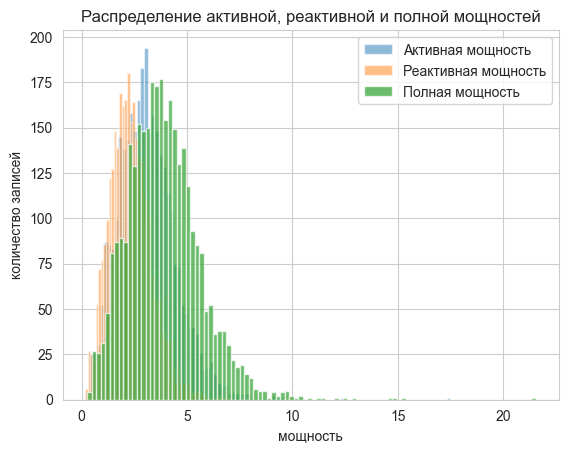

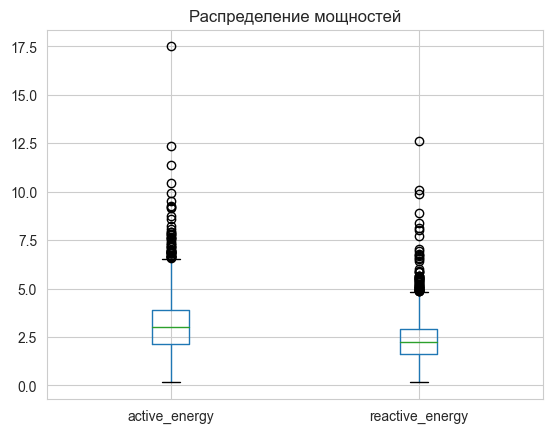

In [23]:
plt.hist(data_arc_groupped['active_energy'], alpha=0.5, bins=100, label='Активная мощность')
plt.hist(data_arc_groupped['reactive_energy'], alpha=0.5, bins=100, label='Реактивная мощность')
plt.hist(data_arc_groupped['full_energy'], alpha=0.7, bins=100, label='Полная мощность')
plt.legend(loc='upper right')
plt.title("Распределение активной, реактивной и полной мощностей", fontsize=12)
plt.xlabel("мощность")
plt.ylabel("количество записей")
plt.show()

data_arc_groupped.boxplot(['active_energy', 'reactive_energy'])
plt.title("Распределение мощностей", fontsize=12)
plt.show()

Распределение мощностей близко к нормальному. Значения реактивной мощности ниже значений активной мощности, а значения активной мощности ниже полной. Встречаются выбросы, но удалять их не будем

Распределение длительности нагрева и работы

In [24]:
def feature_plot_builder (df, feature):
  fig, ax = plt.subplots(figsize=(15, 4), nrows=1, ncols=2)
  fig.subplots_adjust(top=0.90)
    
  df.plot( kind='hist', y=feature, alpha=1, ax=ax[0])
  df.boxplot(feature, ax=ax[1])
        
  plt.suptitle('Распределение ' + feature, fontsize=15, y=0.98)
  plt.show()
  return

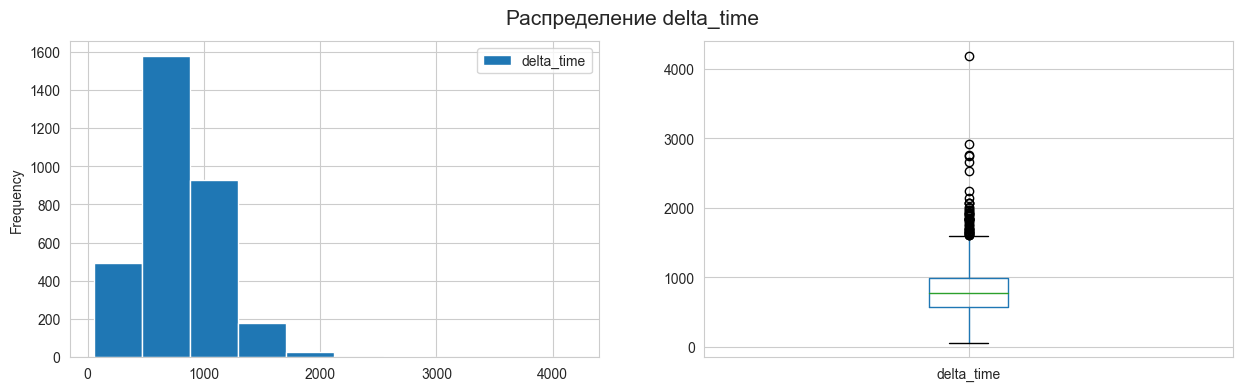

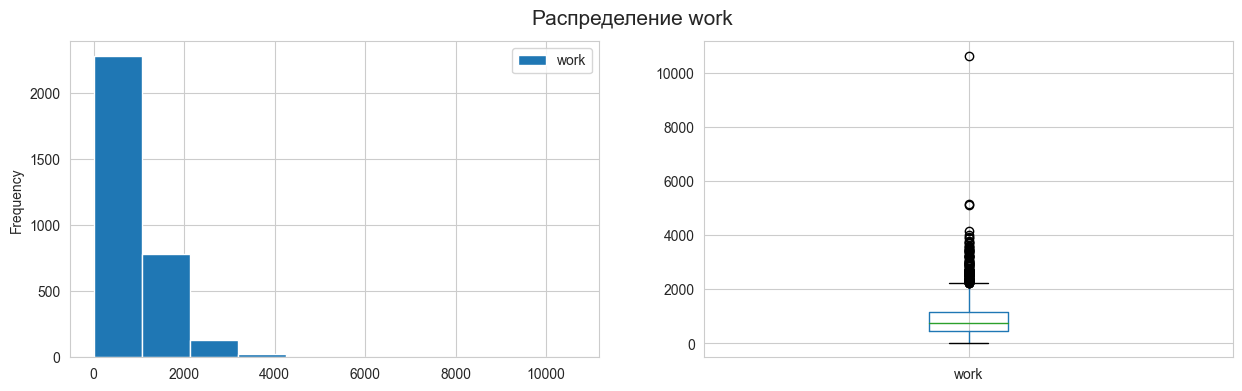

In [25]:
for item in ['delta_time', 'work']:
  feature_plot_builder(data_arc_groupped, item)

Распределения похожи на нормальные. Встречаются выбросы, но удалять их не будем

**Вывод:**
* Столбцы приведены к snake_case
* Обработана аномалия в столбце reactive_energy
* Сформирован датафрейм data_arc_groupped в котором по ключу хранятся суммарные активная, реактивная, полная мощности, а так же суммарная работа и общее время нагрева
* Распределение активной, реактивной, полной мощности, а так же суммарной работы и общего времени нагрева близко к нормальному, выбросы есть, но они вписываются в реальную картину

### Данные о сыпучих продуктах

#### Обработка столбцов

Переименуем столбцы

In [26]:
data_bulk.columns = ['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15']
data_bulk.columns

Index(['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15'],
      dtype='object')

Удалим столбцы 'bulk_2', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_13'

In [27]:
data_bulk = data_bulk.drop(['bulk_2', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_13'], axis=1)
data_bulk.columns

Index(['key', 'bulk_1', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_10',
       'bulk_11', 'bulk_12', 'bulk_14', 'bulk_15'],
      dtype='object')

#### Фильтрация ключей в data_bulk по ключам отсутствующим в data_bulk_time

In [28]:
print('Размер до фильтрации: ', data_bulk.shape)

data_bulk = data_bulk.merge(data_bulk_time['key'], on='key', how='inner')
print('Размер после фильтрации: ', data_bulk.shape)

Размер до фильтрации:  (3129, 11)
Размер после фильтрации:  (3129, 11)


#### Заполнение пропусков

In [29]:
data_bulk = data_bulk.fillna(0)
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3129 entries, 0 to 3128
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   3129 non-null   float64
 2   bulk_3   3129 non-null   float64
 3   bulk_4   3129 non-null   float64
 4   bulk_5   3129 non-null   float64
 5   bulk_6   3129 non-null   float64
 6   bulk_10  3129 non-null   float64
 7   bulk_11  3129 non-null   float64
 8   bulk_12  3129 non-null   float64
 9   bulk_14  3129 non-null   float64
 10  bulk_15  3129 non-null   float64
dtypes: float64(10), int64(1)
memory usage: 293.3 KB


#### Обзор распределения признаков

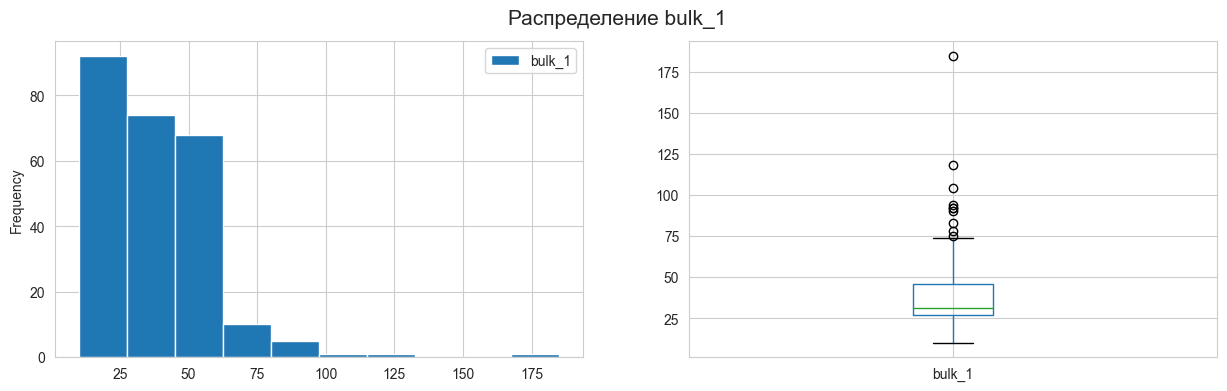

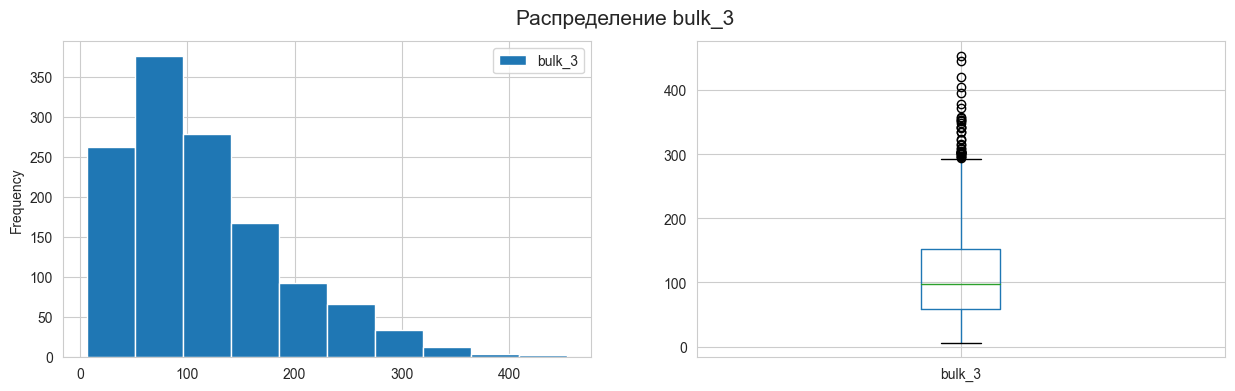

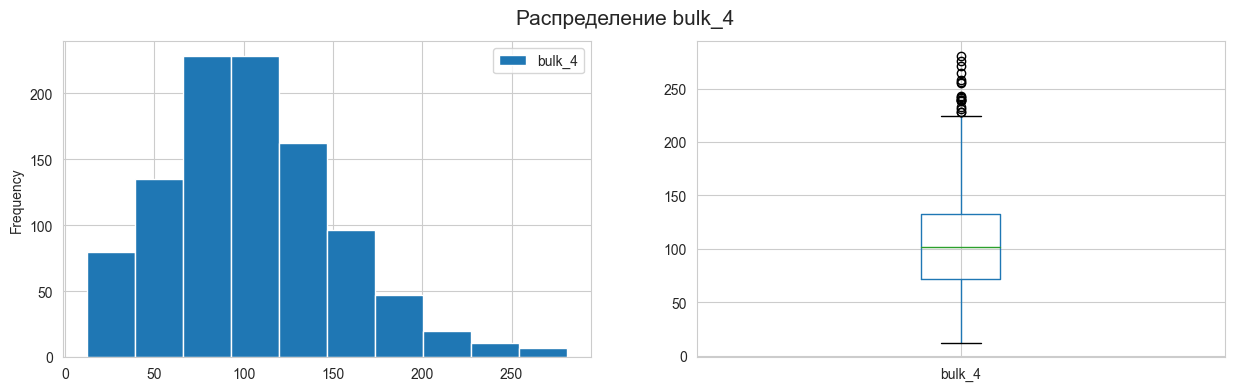

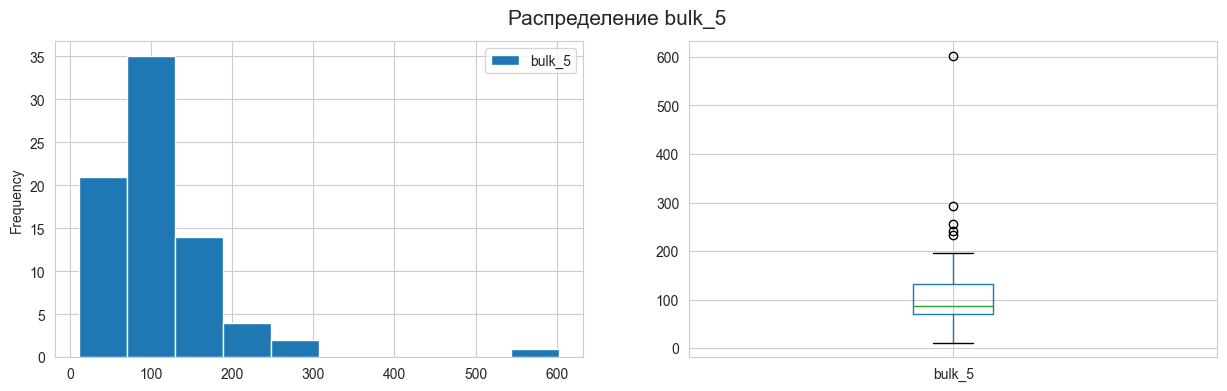

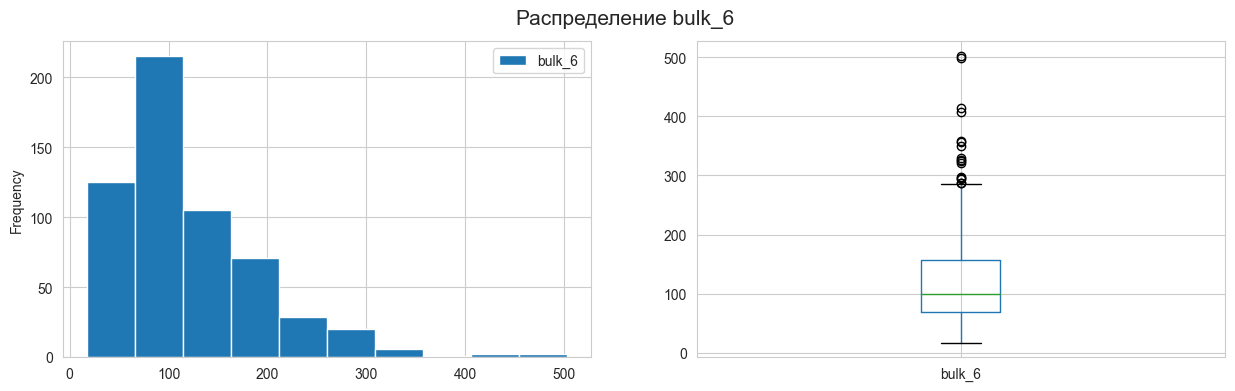

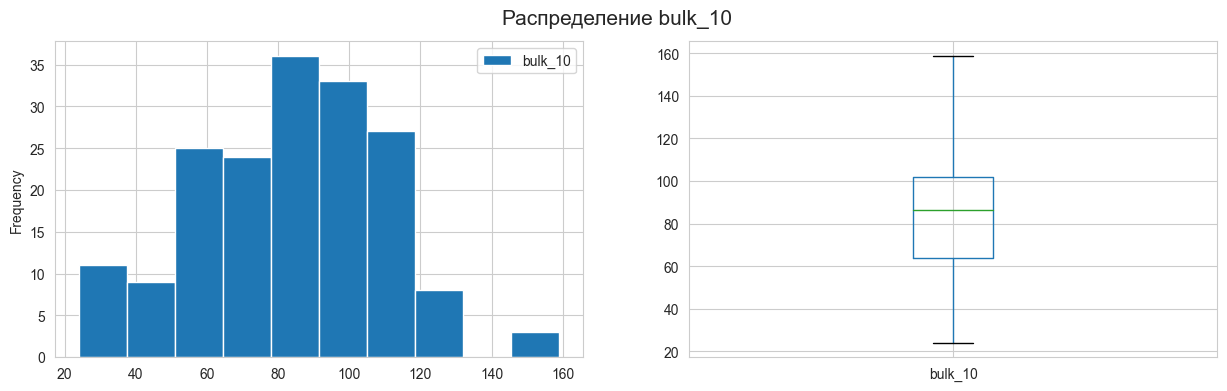

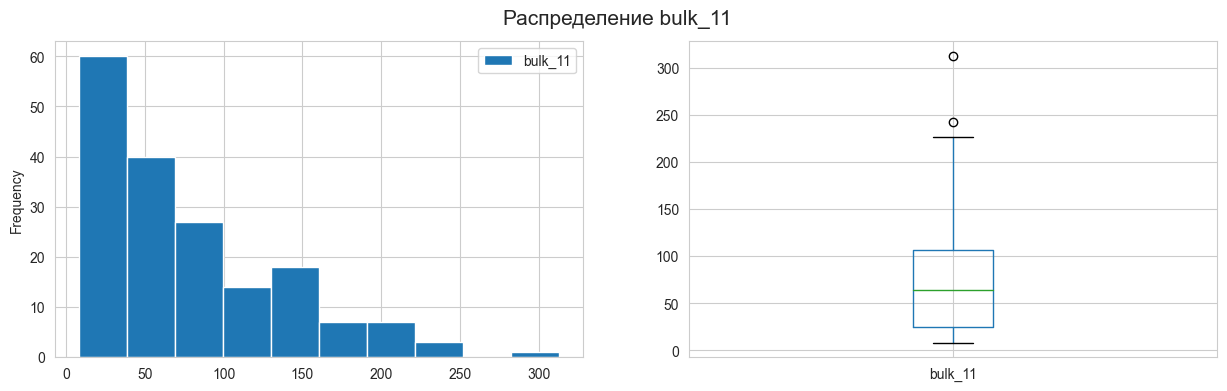

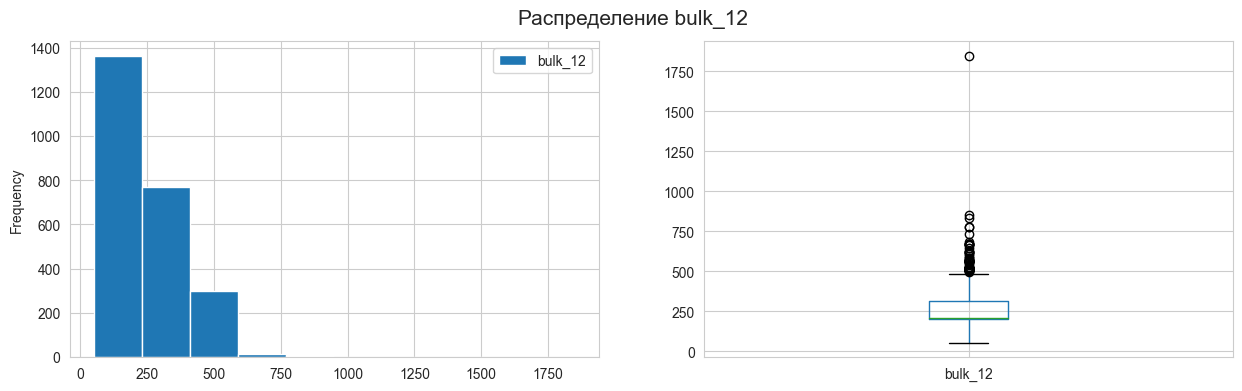

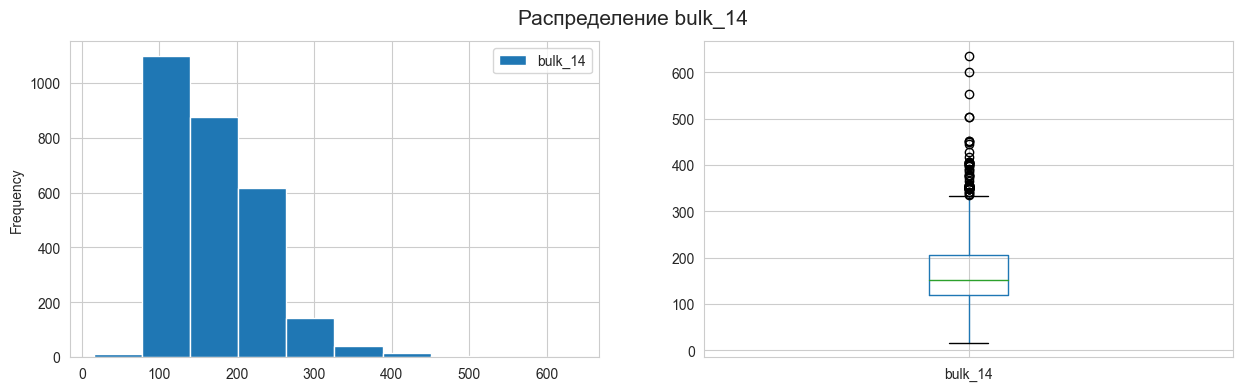

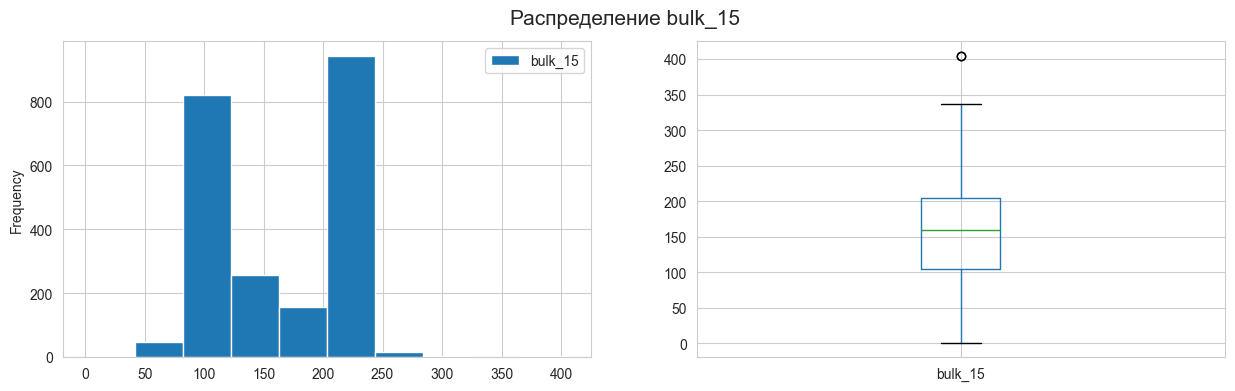

In [30]:
for item in ['bulk_1', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_14', 'bulk_15']:
  feature_plot_builder(data_bulk.query(f"{item} > 0"), item)

**Вывод:**
* Столбцы приведены к snake_case
* Пропуски заполнены нулями
* Распределения bulk_3, bulk_4, bulk_5, bulk_6, bulk_10, bulk_14 похожи на нормальное распределение. 
* Распределения bulk_1, bulk_4, bulk_12, bulk_15 не очень похожи на нормальное (что с этим знанием делать - не знаю :))

### Данные о продувке газом

##### Обработка столбцов

In [31]:
data_gas.columns=['key', 'gas_1']
data_gas.columns

Index(['key', 'gas_1'], dtype='object')

#### Обзор распределения признаков

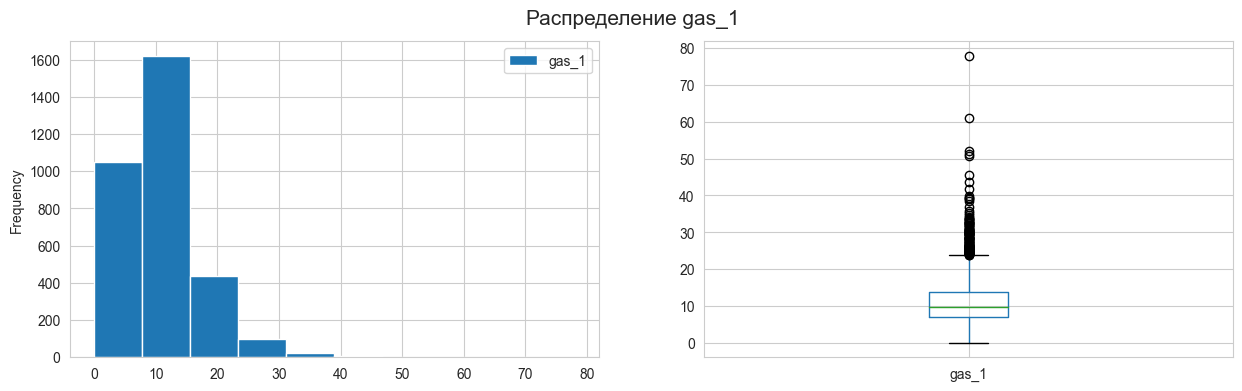

In [32]:
for item in ['gas_1']:
  feature_plot_builder(data_gas, item)

**Вывод:**
* Названия столбцов приведены к snake_case
* Распределение объемов газа близко к нормальному. Встречаются выбросы, но удалять их не будем

### Результаты измерения температуры

#### Обработка столбцов

In [33]:
data_temp.columns=['key', 'time', 'temperature']
data_temp.columns

Index(['key', 'time', 'temperature'], dtype='object')

#### Приведение типов

Столбец  time к типу datetime

In [34]:
data_temp['time'] = pd.to_datetime(data_temp['time'] , format='%Y-%m-%d %H:%M:%S')
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   key          15907 non-null  int64         
 1   time         15907 non-null  datetime64[ns]
 2   temperature  13006 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 372.9 KB


Приводить тип столбца temperature к int будем после обработки пропусков

#### Обработка пропусков
 
 Сформируем новый датафрейм, в котором будут ключ, первое и последнее измерение температуры для данного ключа, а так же количество измерений. Поскольку в рамках задачи нас интересуют только первое и последнее измерение для ключа, то обрабатывать пропуски будем уже на новом датафрейме


In [35]:
data_temp_groupped = (data_temp
              .sort_values(by=['key', 'time'])
              .groupby(by='key', as_index=False).agg({
                  'time': 'count',
                  'temperature': [lambda x: x.iloc[0], lambda y: y.iloc[-1]]
                  })
              )
data_temp_groupped.head()

key  time temperature           
      count  <lambda_0> <lambda_1>
0   1     5     1571.00    1613.00
1   2     6     1581.00    1602.00
2   3     5     1596.00    1599.00
3   4     3     1601.00    1625.00
4   5     2     1576.00    1602.00

In [36]:
data_temp_groupped.columns = ['key', 'count', 'temp_start', 'temp_end']
data_temp_groupped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3216 entries, 0 to 3215
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   key         3216 non-null   int64  
 1   count       3216 non-null   int64  
 2   temp_start  3216 non-null   float64
 3   temp_end    2477 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 100.6 KB


Посмотрим, что посчиталось правильно

In [37]:
data_temp_groupped.head(2)

,key,count,temp_start,temp_end
0,1,5,1571.00,1613.00
1,2,6,1581.00,1602.00


In [38]:
data_temp.query('key in [1, 2]')

,key,time,temperature
0,1,2019-05-03 11:16:18,1571.00
1,1,2019-05-03 11:25:53,1604.00
2,1,2019-05-03 11:29:11,1618.00
3,1,2019-05-03 11:30:01,1601.00
4,1,2019-05-03 11:30:39,1613.00
5,2,2019-05-03 11:37:27,1581.00
6,2,2019-05-03 11:38:00,1577.00
7,2,2019-05-03 11:49:38,1589.00
8,2,2019-05-03 11:55:50,1604.00
9,2,2019-05-03 11:58:24,1608.00


Посмотрим записи с NaN в последнем замере

In [39]:
data_temp_groupped[data_temp_groupped.temp_end.isna()].head(2)

,key,count,temp_start,temp_end
2477,2500,4,1539.00,NaN
2478,2501,5,1587.00,NaN


In [40]:
data_temp.query('key in [2500, 2501]')

,key,time,temperature
12267,2500,2019-08-06 03:11:31,1539.00
12268,2500,2019-08-06 03:24:43,NaN
12269,2500,2019-08-06 03:25:16,NaN
12270,2500,2019-08-06 03:28:21,NaN
12271,2501,2019-08-06 03:44:42,1587.00
12272,2501,2019-08-06 04:01:59,NaN
12273,2501,2019-08-06 04:14:35,NaN
12274,2501,2019-08-06 04:22:14,NaN
12275,2501,2019-08-06 04:31:14,NaN


Удалим записи, где count == 1. Поскольку нас интересуют только те ключи, где минимум 2 показания температуры

In [41]:
data_temp_groupped = data_temp_groupped.query('count > 1')

Удалим записи, где есть пропуски

In [42]:
data_temp_groupped = data_temp_groupped.dropna()
data_temp_groupped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 0 to 2476
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   key         2475 non-null   int64  
 1   count       2475 non-null   int64  
 2   temp_start  2475 non-null   float64
 3   temp_end    2475 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 96.7 KB


**Приведём столбцы temp_start и temp_end к типу datetime**

In [43]:

try:
    data_temp_groupped['temp_start'] = data_temp_groupped['temp_start'].astype('int64')
except:
    print("Не удалось преобразовать столбец 'temp_start'")

try:
    data_temp_groupped['temp_end'] = data_temp_groupped['temp_end'].astype('int64')
except:
    print("Не удалось преобразовать столбец 'temp_end'")    

Удалим столбец count

In [44]:
data_temp_groupped = data_temp_groupped.drop('count', axis=1)

В дальнейшем исследовании будем использовать датафрейм data_temp_groupped.

#### Фильтрация выбросов
Удалим ключи с начальной температурой ниже 1500, для таких значений будут в дальнейшем обучать отдельную модель

In [45]:
print('Количество записей до фильтрации:', len(data_temp_groupped))

data_temp_groupped = data_temp_groupped.query('temp_start >= 1500')
print('Количество записей после фильтрации:', len(data_temp_groupped))

Количество записей до фильтрации: 2475
Количество записей после фильтрации: 2471


#### Обзор распределения признаков

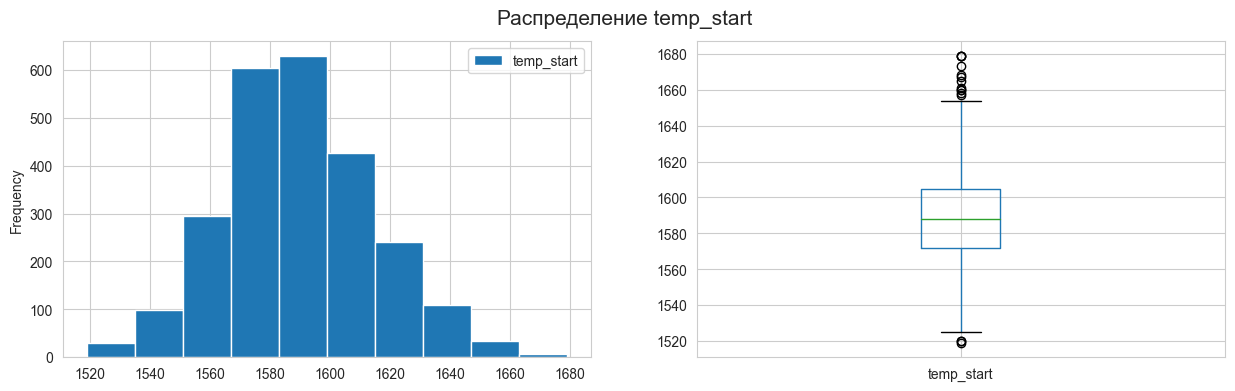

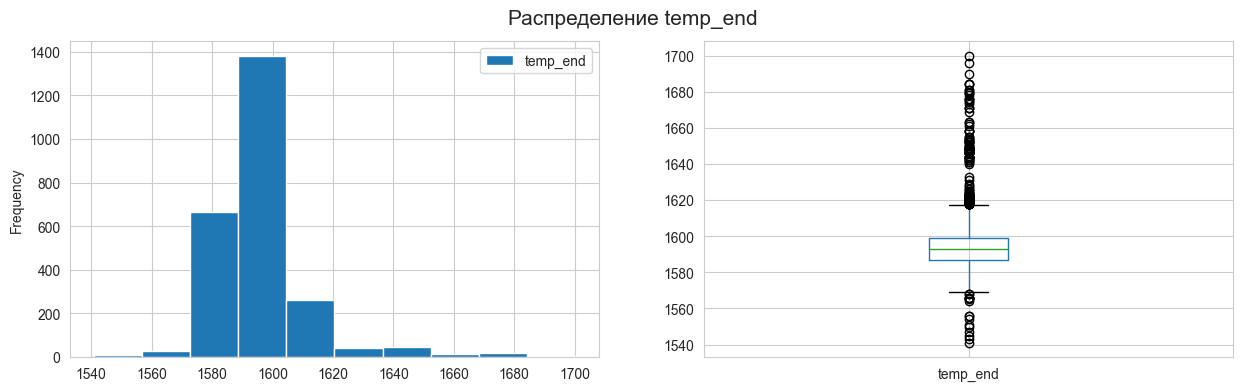

In [46]:
for item in ['temp_start', 'temp_end']:
  feature_plot_builder(data_temp_groupped, item)

**Вывод:**
* Столбцы приведены к snake_case
* Сформирован датафрейм data_temp_groupped в котором по ключу хранятся начальная и конечная температуры
* Отфильтрованы ключи с пропусками в конечной температуре
* Отфильтрованы ключи с начальной температурой ниже 1500
* Распределения признаков похожи на нормальное

### Данные о проволочных материалах

####  Обработка столбцов

Переименуем столбцы

In [47]:
data_wire.columns = ['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9']
data_wire.columns

Index(['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_8', 'wire_9'],
      dtype='object')

Удалим столбцы wire_4, wire_5, wire_7, wire_8, wire_9

In [48]:
data_wire = data_wire.drop(['wire_4', 'wire_5', 'wire_7', 'wire_8', 'wire_9'], axis=1)
data_wire.columns

Index(['key', 'wire_1', 'wire_2', 'wire_3', 'wire_6'], dtype='object')

#### Фильтрация ключей по данным из data_wire_time

In [49]:
print('Размер до фильтрации: ', data_wire.shape)

data_wire = data_wire.merge(data_wire_time['key'], on='key', how='inner')
print('Размер после фильтрации: ', data_wire.shape)

Размер до фильтрации:  (3081, 5)
Размер после фильтрации:  (3081, 5)


Размер data_wire не изменился. Данные были корректные

#### Обработка пропусков

Поскольку пропуск означает, что данную проволоку не добавляли, то заполним пропуски 0

In [50]:
data_wire = data_wire.fillna(0)
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3081 entries, 0 to 3080
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3081 non-null   float64
 2   wire_2  3081 non-null   float64
 3   wire_3  3081 non-null   float64
 4   wire_6  3081 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 144.4 KB


#### Обзор распределения признаков

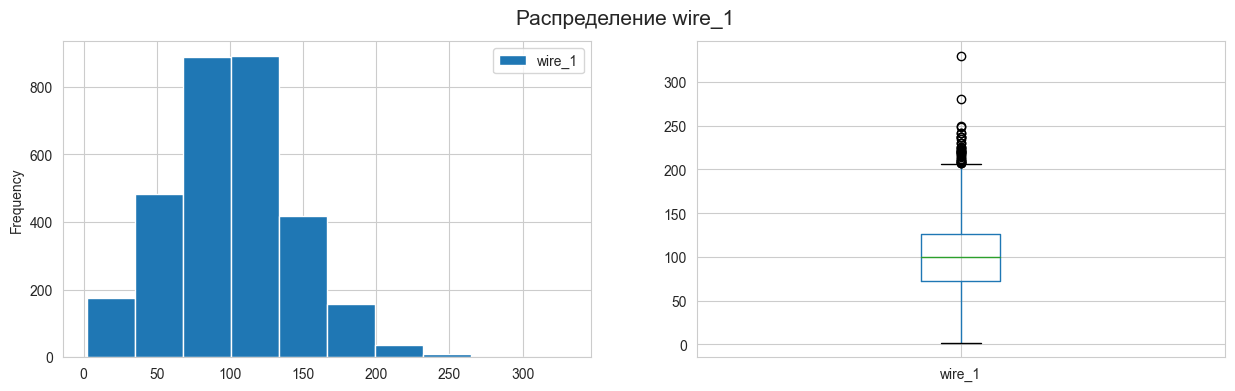

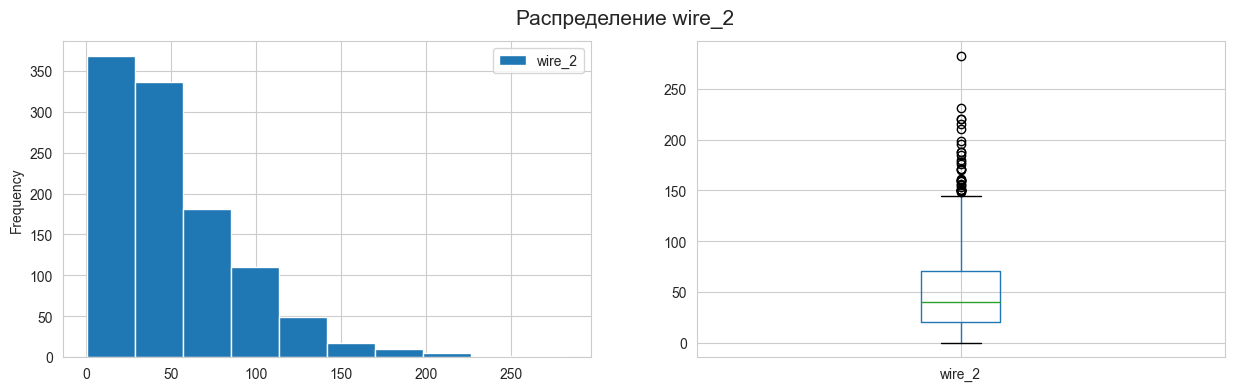

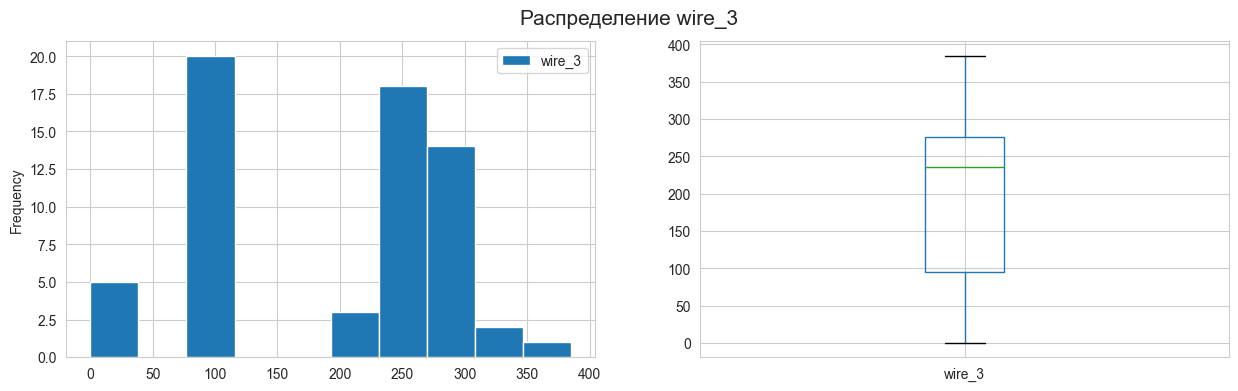

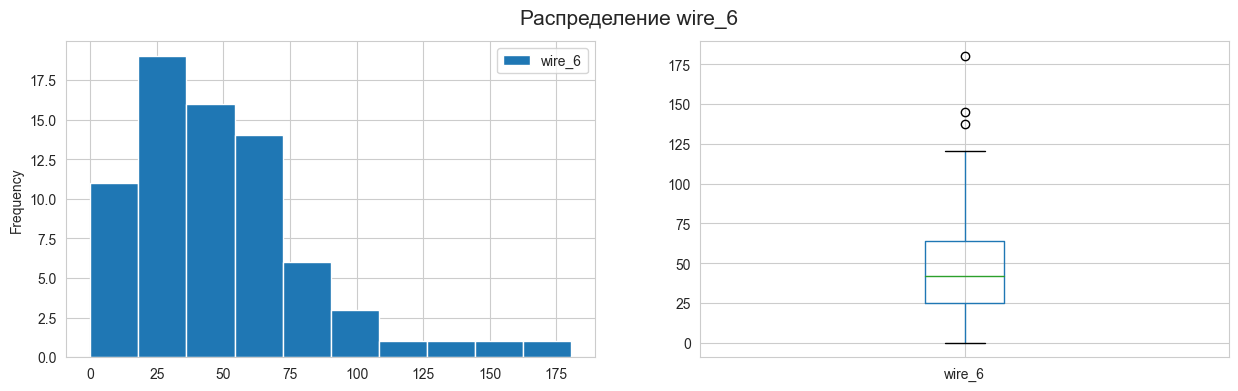

In [51]:
for item in ['wire_1', 'wire_2', 'wire_3', 'wire_6']:
  feature_plot_builder(data_wire.query(f"{item} > 0"), item)

**Вывод:**
* Столбцы приведены к snake_case
* Удалены столбцы wire_4, wire_5, wire_7, wire_8, wire_9, поскольку в них слишком мало данных
* Распределения 'wire_1', 'wire_2', 'wire_6' близки к нормальному. Встречаются выбросы, но удалять их не будем. Распределение wire_5 - на нормальное не похоже, но при этом здесь возможно недостаточное количество наблюдений.

### Вывод по разделу
* Названия столбцов приведены к snake_case
* Сформирован датафрейм data_arc_groupped в котором по ключу хранятся суммарные активная, реактивная, полная мощности, а так же суммарная работа и общее время нагрева
* Сформирован датафрейм data_temp_groupped в котором по ключу хранятся начальная и конечная температуры
* Отфильтрованы ключи с пропусками в конечной температуре
* Отфильтрованы ключи с начальной температурой ниже 1500
* Распределения признаков похожи на нормальные за исключением признаков bulk_1, bulk_4, bulk_12, bulk_15, wire_5
* В данных встречаются выбросы, но их не стали отфильтровывать за исключением конечной температуры


## Подготовка признаков

### Формирование общего датафрейма со всеми признаками

In [52]:
data_final = (data_temp_groupped
              .merge(data_arc_groupped, on='key', how='inner')
              .merge(data_bulk, on='key', how='inner')
              .merge(data_gas, on='key', how='inner')
              .merge(data_wire, on='key', how='inner')
              )

data_final.head(10)

,key,temp_start,temp_end,active_energy,reactive_energy,full_energy,delta_time,work,bulk_1,bulk_3,...,bulk_10,bulk_11,bulk_12,bulk_14,bulk_15,gas_1,wire_1,wire_2,wire_3,wire_6
0,1,1571,1613,4.88,3.18,5.83,1098.00,1442.38,0.00,0.00,...,0.00,0.00,206.00,150.00,154.00,29.75,60.06,0.00,0.00,0.00
1,2,1581,1602,3.05,2.00,3.65,811.00,881.23,0.00,0.00,...,0.00,0.00,206.00,149.00,154.00,12.56,96.05,0.00,0.00,0.00
2,3,1596,1599,2.53,1.60,2.99,655.00,525.07,0.00,0.00,...,0.00,0.00,205.00,152.00,153.00,28.55,91.16,0.00,0.00,0.00
3,4,1601,1625,3.21,2.06,3.81,741.00,796.91,0.00,0.00,...,0.00,0.00,207.00,153.00,154.00,18.84,89.06,0.00,0.00,0.00
4,5,1576,1602,3.35,2.25,4.04,869.00,1199.14,0.00,0.00,...,0.00,0.00,203.00,151.00,152.00,5.41,89.24,9.11,0.00,0.00
5,6,1543,1596,3.96,2.69,4.79,952.00,1410.75,0.00,0.00,...,0.00,0.00,204.00,201.00,154.00,11.27,99.11,9.11,0.00,0.00
6,7,1586,1599,2.55,1.56,2.99,673.00,729.78,0.00,0.00,...,0.00,0.00,204.00,152.00,154.00,9.84,98.06,0.00,0.00,0.00
7,8,1577,1598,3.76,2.68,4.63,913.00,1550.54,0.00,0.00,...,0.00,0.00,410.00,252.00,153.00,15.17,155.28,0.00,0.00,0.00
8,9,1587,1592,2.08,1.48,2.56,625.00,406.46,0.00,0.00,...,0.00,0.00,107.00,99.00,203.00,8.22,113.39,9.14,0.00,0.00
9,10,1574,1593,2.92,2.50,3.85,825.00,617.36,0.00,0.00,...,0.00,0.00,203.00,102.00,204.00,6.53,81.24,12.38,0.00,0.00


In [53]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 0 to 2324
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   key              2325 non-null   int64  
 1   temp_start       2325 non-null   int64  
 2   temp_end         2325 non-null   int64  
 3   active_energy    2325 non-null   float64
 4   reactive_energy  2325 non-null   float64
 5   full_energy      2325 non-null   float64
 6   delta_time       2325 non-null   float64
 7   work             2325 non-null   float64
 8   bulk_1           2325 non-null   float64
 9   bulk_3           2325 non-null   float64
 10  bulk_4           2325 non-null   float64
 11  bulk_5           2325 non-null   float64
 12  bulk_6           2325 non-null   float64
 13  bulk_10          2325 non-null   float64
 14  bulk_11          2325 non-null   float64
 15  bulk_12          2325 non-null   float64
 16  bulk_14          2325 non-null   float64
 17  bulk_15       

### Фильтрация признаков

Посмотрим корреляцию признаков

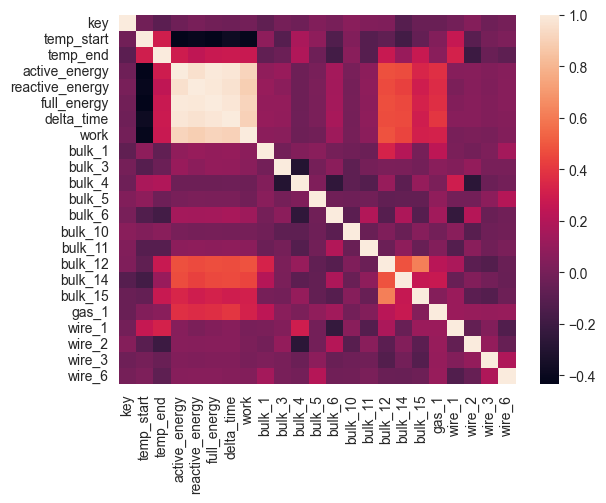

In [54]:
sns.heatmap(data_final.corr())
plt.show()

* Заметна высока корреляция для признаков: active_energy	reactive_energy	full_energy	delta_time	work
* Для остальных признаков зависимости близкой к линейной нет


In [55]:
data_final[['active_energy', 'reactive_energy', 'full_energy', 'delta_time', 'work', 'temp_end']].corr()

,active_energy,reactive_energy,full_energy,delta_time,work,temp_end
active_energy,1.00,0.96,0.99,0.98,0.91,0.29
reactive_energy,0.96,1.00,0.98,0.97,0.89,0.24
full_energy,0.99,0.98,1.00,0.98,0.91,0.27
delta_time,0.98,0.97,0.98,1.00,0.90,0.28
work,0.91,0.89,0.91,0.90,1.00,0.27
temp_end,0.29,0.24,0.27,0.28,0.27,1.00


Удалим признаки: reactive_energy,	full_energy,	delta_time. Оставим active_energy, поскольку у нее самая высока корреляция с temp_end и work, поскольку она объединяет 2 признака (full_energy, delta_time). Пробуем обучить модель либо с active_energy, либо с work, и выберем какой признак оставить исходя из лучшей метрики

In [56]:
data_final = data_final.drop(['reactive_energy', 'full_energy', 'delta_time'], axis=1)
data_final.columns

Index(['key', 'temp_start', 'temp_end', 'active_energy', 'work', 'bulk_1',
       'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_14', 'bulk_15', 'gas_1', 'wire_1', 'wire_2', 'wire_3', 'wire_6'],
      dtype='object')

In [57]:
data_final.describe()

,key,temp_start,temp_end,active_energy,work,bulk_1,bulk_3,bulk_4,bulk_5,bulk_6,bulk_10,bulk_11,bulk_12,bulk_14,bulk_15,gas_1,wire_1,wire_2,wire_3,wire_6
count,2325.00,2325.00,2325.00,2325.00,2325.00,2325.00,2325.00,2325.00,2325.00,2325.00,2325.00,2325.00,2325.00,2325.00,2325.00,2325.00,2325.00,2325.00,2325.00,2325.00
mean,1251.51,1587.37,1593.37,3.15,903.61,3.43,47.30,37.33,2.64,22.47,5.06,4.25,208.51,153.97,120.03,11.38,102.41,17.61,3.24,0.98
std,715.10,23.62,11.21,1.43,651.03,12.42,75.23,58.67,22.42,55.83,20.93,22.53,157.14,81.40,84.67,6.40,43.54,33.64,27.97,8.70
min,1.00,1519.00,1541.00,0.19,15.16,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00
25%,629.00,1571.00,1587.00,2.17,465.24,0.00,0.00,0.00,0.00,0.00,0.00,0.00,105.00,105.00,0.00,7.28,73.21,0.00,0.00,0.00
50%,1255.00,1587.00,1593.00,3.03,767.83,0.00,0.00,0.00,0.00,0.00,0.00,0.00,206.00,149.00,107.00,10.10,101.09,0.00,0.00,0.00
75%,1868.00,1603.00,1598.00,3.92,1166.36,0.00,80.00,77.00,0.00,0.00,0.00,0.00,283.00,204.00,204.00,14.22,128.07,23.10,0.00,0.00
max,2499.00,1660.00,1653.00,17.50,10630.98,185.00,454.00,281.00,603.00,503.00,159.00,313.00,1849.00,636.00,405.00,78.00,330.31,282.78,385.01,180.45


Удалим признак key, т.к. он не влияет на конечную температуру. Так же удалим признак bulk_5, поскольку там слишком мало данных

In [58]:
data_final = data_final.drop(['key', 'bulk_5'], axis=1)
data_final.columns

Index(['temp_start', 'temp_end', 'active_energy', 'work', 'bulk_1', 'bulk_3',
       'bulk_4', 'bulk_6', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_14',
       'bulk_15', 'gas_1', 'wire_1', 'wire_2', 'wire_3', 'wire_6'],
      dtype='object')

### Выделение целевого признака

In [59]:
features = data_final.drop(['temp_end'], axis=1)
target = data_final['temp_end']

### Разбиение данных на тестовую и обучающую выборки

In [60]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345
)

print('Размер обучающей выборки:', len(features_train))
print('Размер тестовой выборки:', len(features_test))

Размер обучающей выборки: 1743
Размер тестовой выборки: 582


**Вывод**
* Сформирован общий датафрейм со всеми признаками
* Удалены признаки с высокой корреляцией
* Выделен целевой признак
* Выборки поделены на тестовую и обучающую

## Подбор параметров для моделей

### Модель линейная регрессия

In [61]:
pipe = Pipeline([
        ('scale', StandardScaler()),
        ('mod', LinearRegression())
    ])

mean_mae = -cross_val_score(pipe, features_train, target_train, scoring='neg_mean_absolute_error', cv=5).mean()
print(mean_mae)

6.0751028988579465


Усредненное MAE равно 6.07

### Модель дерево решений

In [62]:
model = DecisionTreeRegressor(random_state=250722)
parameters = {'max_depth': range (3, 10, 1)}
grid = GridSearchCV(model, param_grid=parameters, scoring ='neg_mean_absolute_error', cv=5)
grid.fit(features_train, target_train)

print('Лучшие параметры', grid.best_params_)
print('MAE', -grid.best_score_)

Лучшие параметры {'max_depth': 5}
MAE 6.620453285826905


Лучшие параметры {'max_depth': 5}. Усреднённое MAE 6.62

### Модель случайный лес

In [63]:
model = RandomForestRegressor(random_state=250722)
parameters = {'n_estimators': range (10, 130, 10), 'max_depth': range (5, 15, 2)}
grid = GridSearchCV(model, parameters, scoring ='neg_mean_absolute_error', cv=5)
grid.fit(features_train, target_train)

print('Лучшие параметры', grid.best_params_)
print('MAE', -grid.best_score_)

Лучшие параметры {'max_depth': 11, 'n_estimators': 120}
MAE 5.871917586268816



Лучшие параметры {'max_depth': 11, 'n_estimators': 120}. MAE 5.87

### Модель градиентный бустинг

In [64]:
pipe = Pipeline([
        ('scale', StandardScaler()),
        ('mod', lgb.LGBMRegressor(random_state=250722))
    ])
parameters = {'mod__n_estimators': range(50, 200, 20),
               'mod__learning_rate': np.arange(0.01, 0.1, 0.02),
               'mod__max_depth': range(5, 10)
               }

grid_lgbm = GridSearchCV(estimator = pipe, param_grid = parameters, n_jobs = -1, scoring = 'neg_mean_absolute_error', cv=5, verbose=10)
grid_lgbm.fit(features_train, target_train)
print('Лучшие параметры', grid_lgbm.best_params_)
print('MAE', -grid_lgbm.best_score_)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Лучшие параметры {'mod__learning_rate': 0.06999999999999999, 'mod__max_depth': 7, 'mod__n_estimators': 50}
MAE 5.791032620244685


Лучшие параметры {'learning_rate': 0.03, 'max_depth': 7, 'n_estimators': 50}. MAE 5.79

7### Вывод по разделу

* Лучшее усредненное MAE показала модель градиентного бустинга {'learning_rate': 0.07, 'max_depth': 7, 'n_estimators': 50} - 5.79
* На втором месте модель случайный лес  {'max_depth': 11, 'n_estimators': 120}. MAE 5.87
* На третьем - линейная регрессия MAE 6.07
* На последнем - дерево решений {'max_depth': 5} MAE 6.62

## Тестирование модели

In [65]:
%%time

pipe = Pipeline([
        ('scale', StandardScaler()),
        ('mod', lgb.LGBMRegressor(random_state=250722, n_estimators=50, max_depth=7, learning_rate=0.07))
    ])
pipe.fit(features_train, target_train)

CPU times: total: 359 ms
Wall time: 53.4 ms


Pipeline(steps=[('scale', StandardScaler()),
                ('mod',
                 LGBMRegressor(learning_rate=0.07, max_depth=7, n_estimators=50,
                               random_state=250722))])

In [66]:
%time
predictions = pipe.predict(features_test)
mae =  mean_absolute_error(target_test, predictions)
print("MAE модели на тестовой выборке:", mae)

CPU times: total: 0 ns
Wall time: 0 ns
MAE модели на тестовой выборке: 6.3030862178973255


Модель градиентного бустинга {'learning_rate': 0.07, 'max_depth': 7, 'n_estimators': 50} на тестовых данных показала MAE = 6.3.

## Общий вывод

Была проделана следующая работа:
* проведена предобработка данных, в ходе которой были рассчитаны новые признаки
* признаки были масштабированы
* в процессе исследования были удалены признаки 'key', 'bulk_5', 'reactive_energy', 'full_energy', 'delta_time'
* при подборе параметров лучшее значение усредненной MAE показала модель градиентного бустинга {'learning_rate': 0.07, 'max_depth': 7, 'n_estimators': 50} (5.79)
* на тестовых данных данная модель показала MAE = 6.3